## Moving Averages


- Implementing multiple moving average cross-overs in Python provides a hands-on way to explore and visualize these trading signals. Let’s dive into how you can do this effectively using different moving average methods and time-scales.

- Simple Moving Average (SMA): This is the average stock price over a specified number of days.
- Exponential Moving Average (EMA): EMA gives more weight to recent prices, making it more responsive to new information.
- Weighted Moving Average (WMA): WMA assigns a weighted multiplier to prices, emphasizing particular periods.

[*********************100%%**********************]  1 of 1 completed


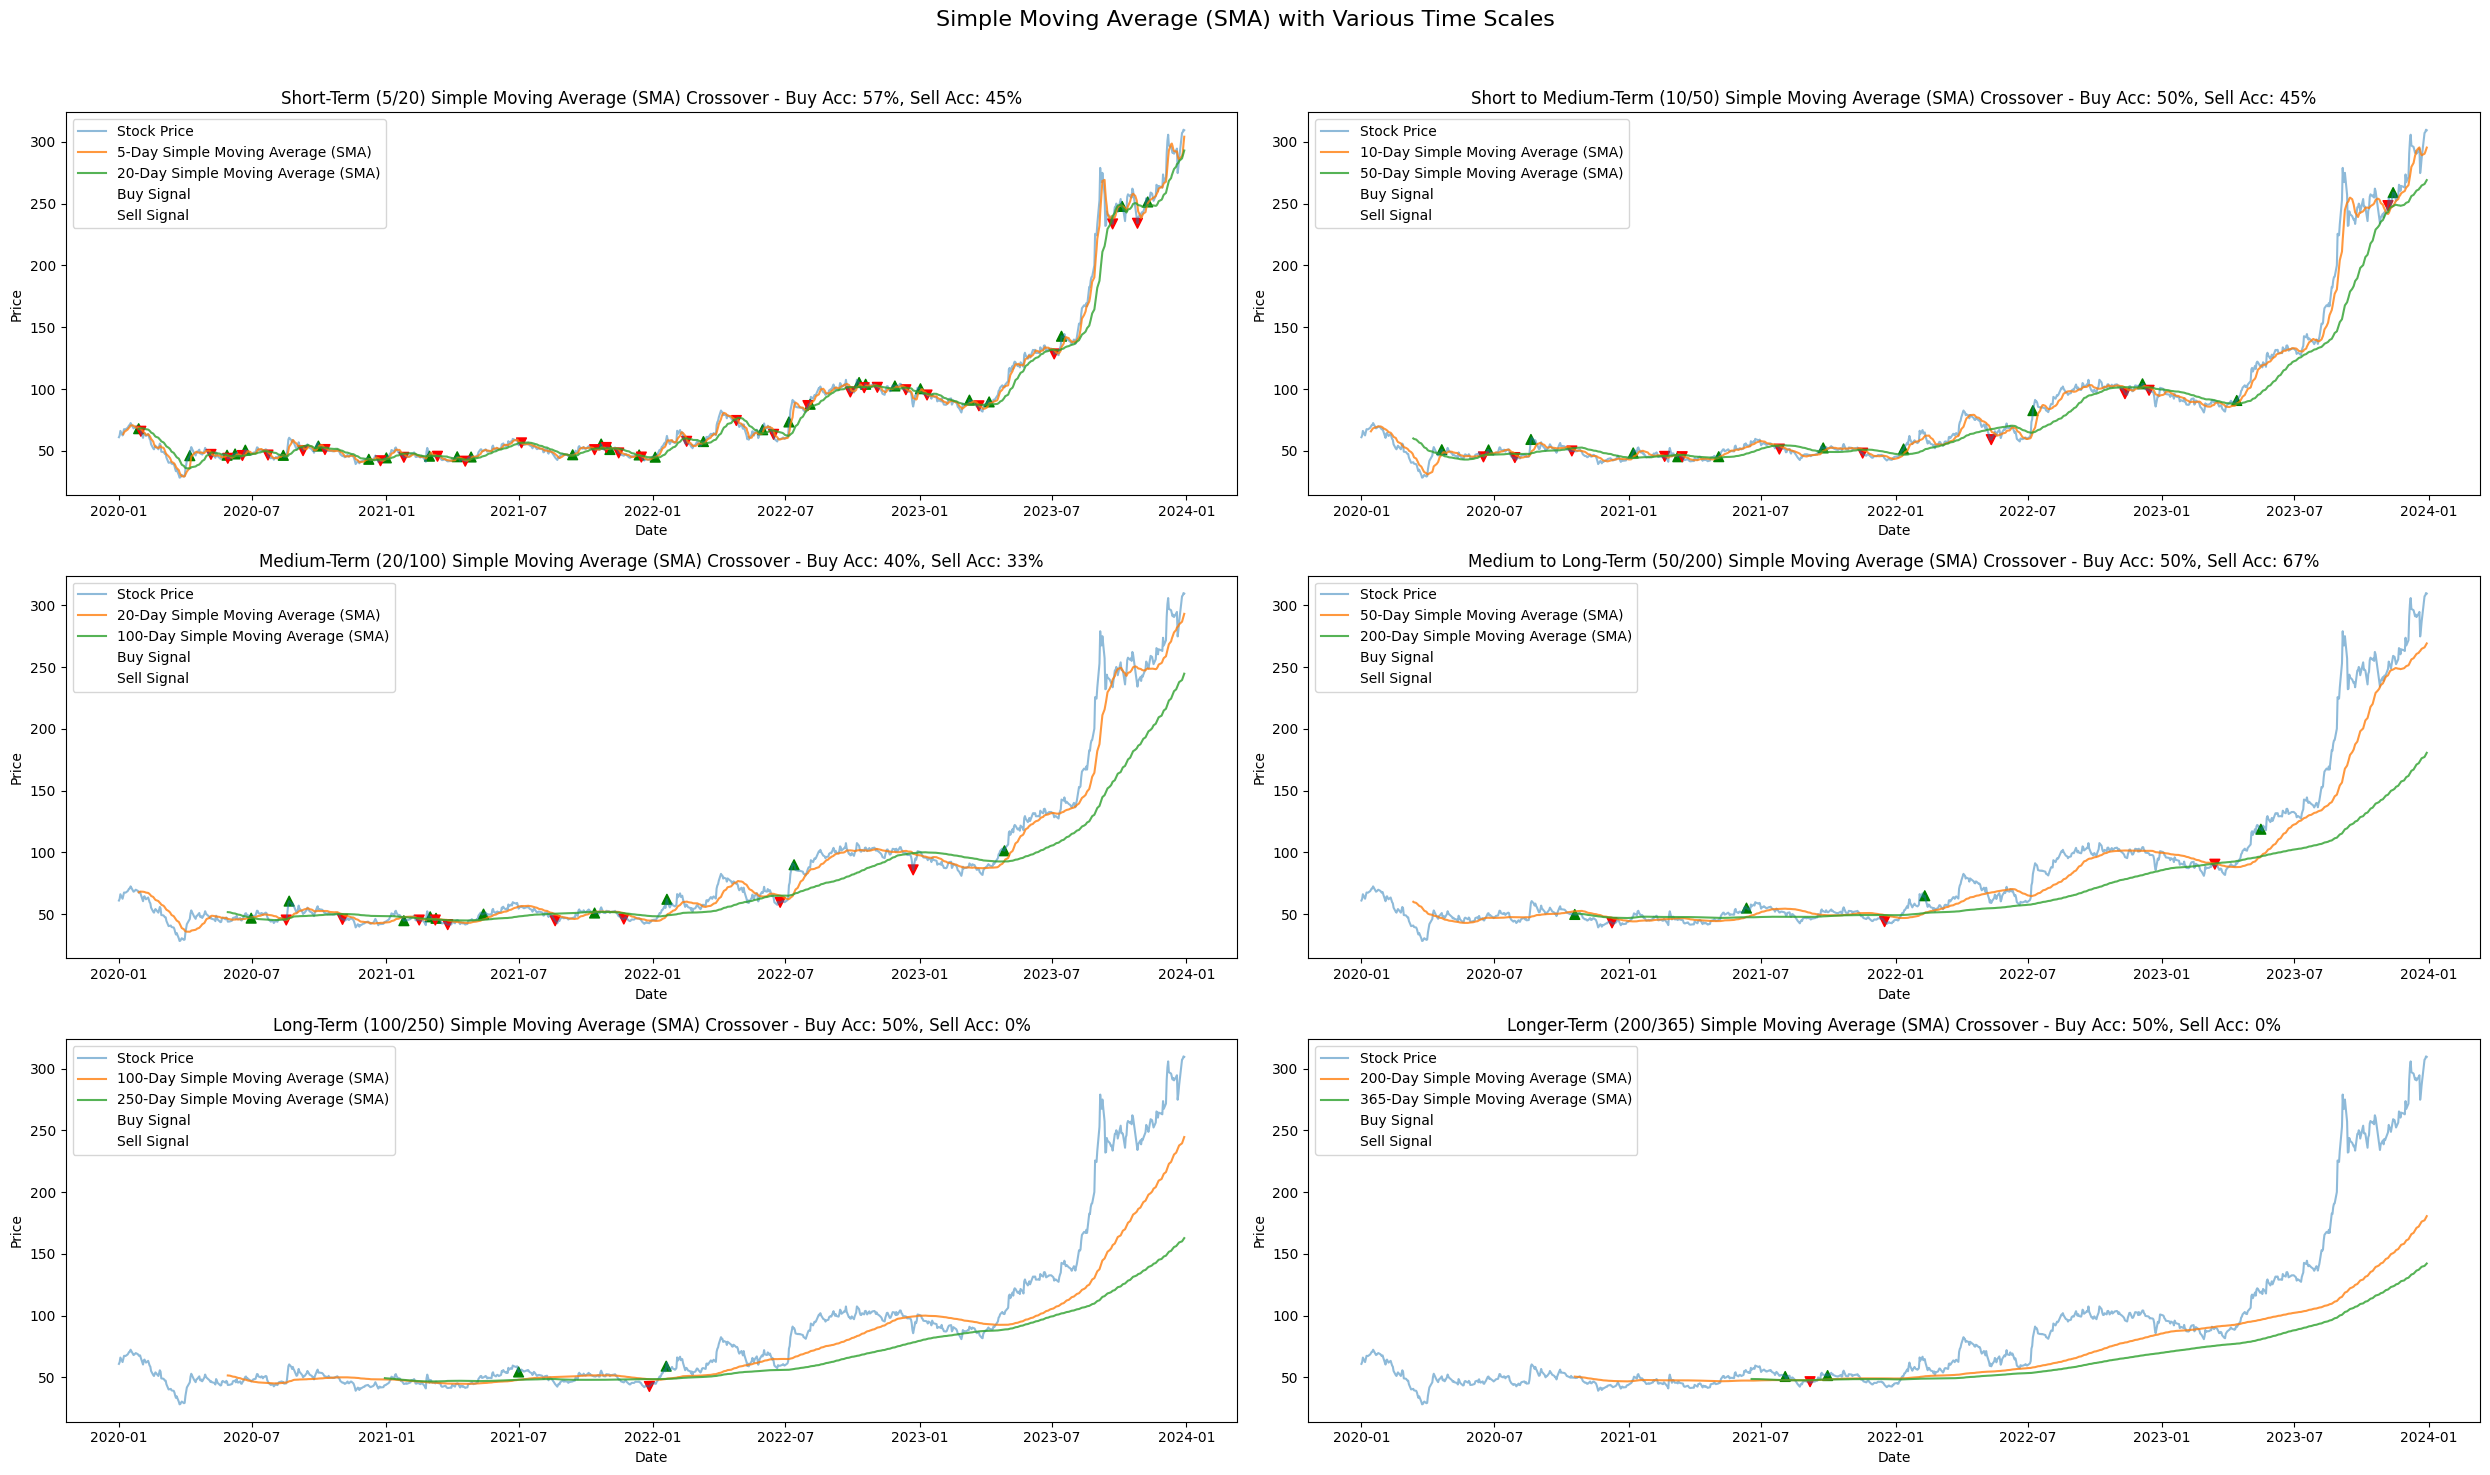

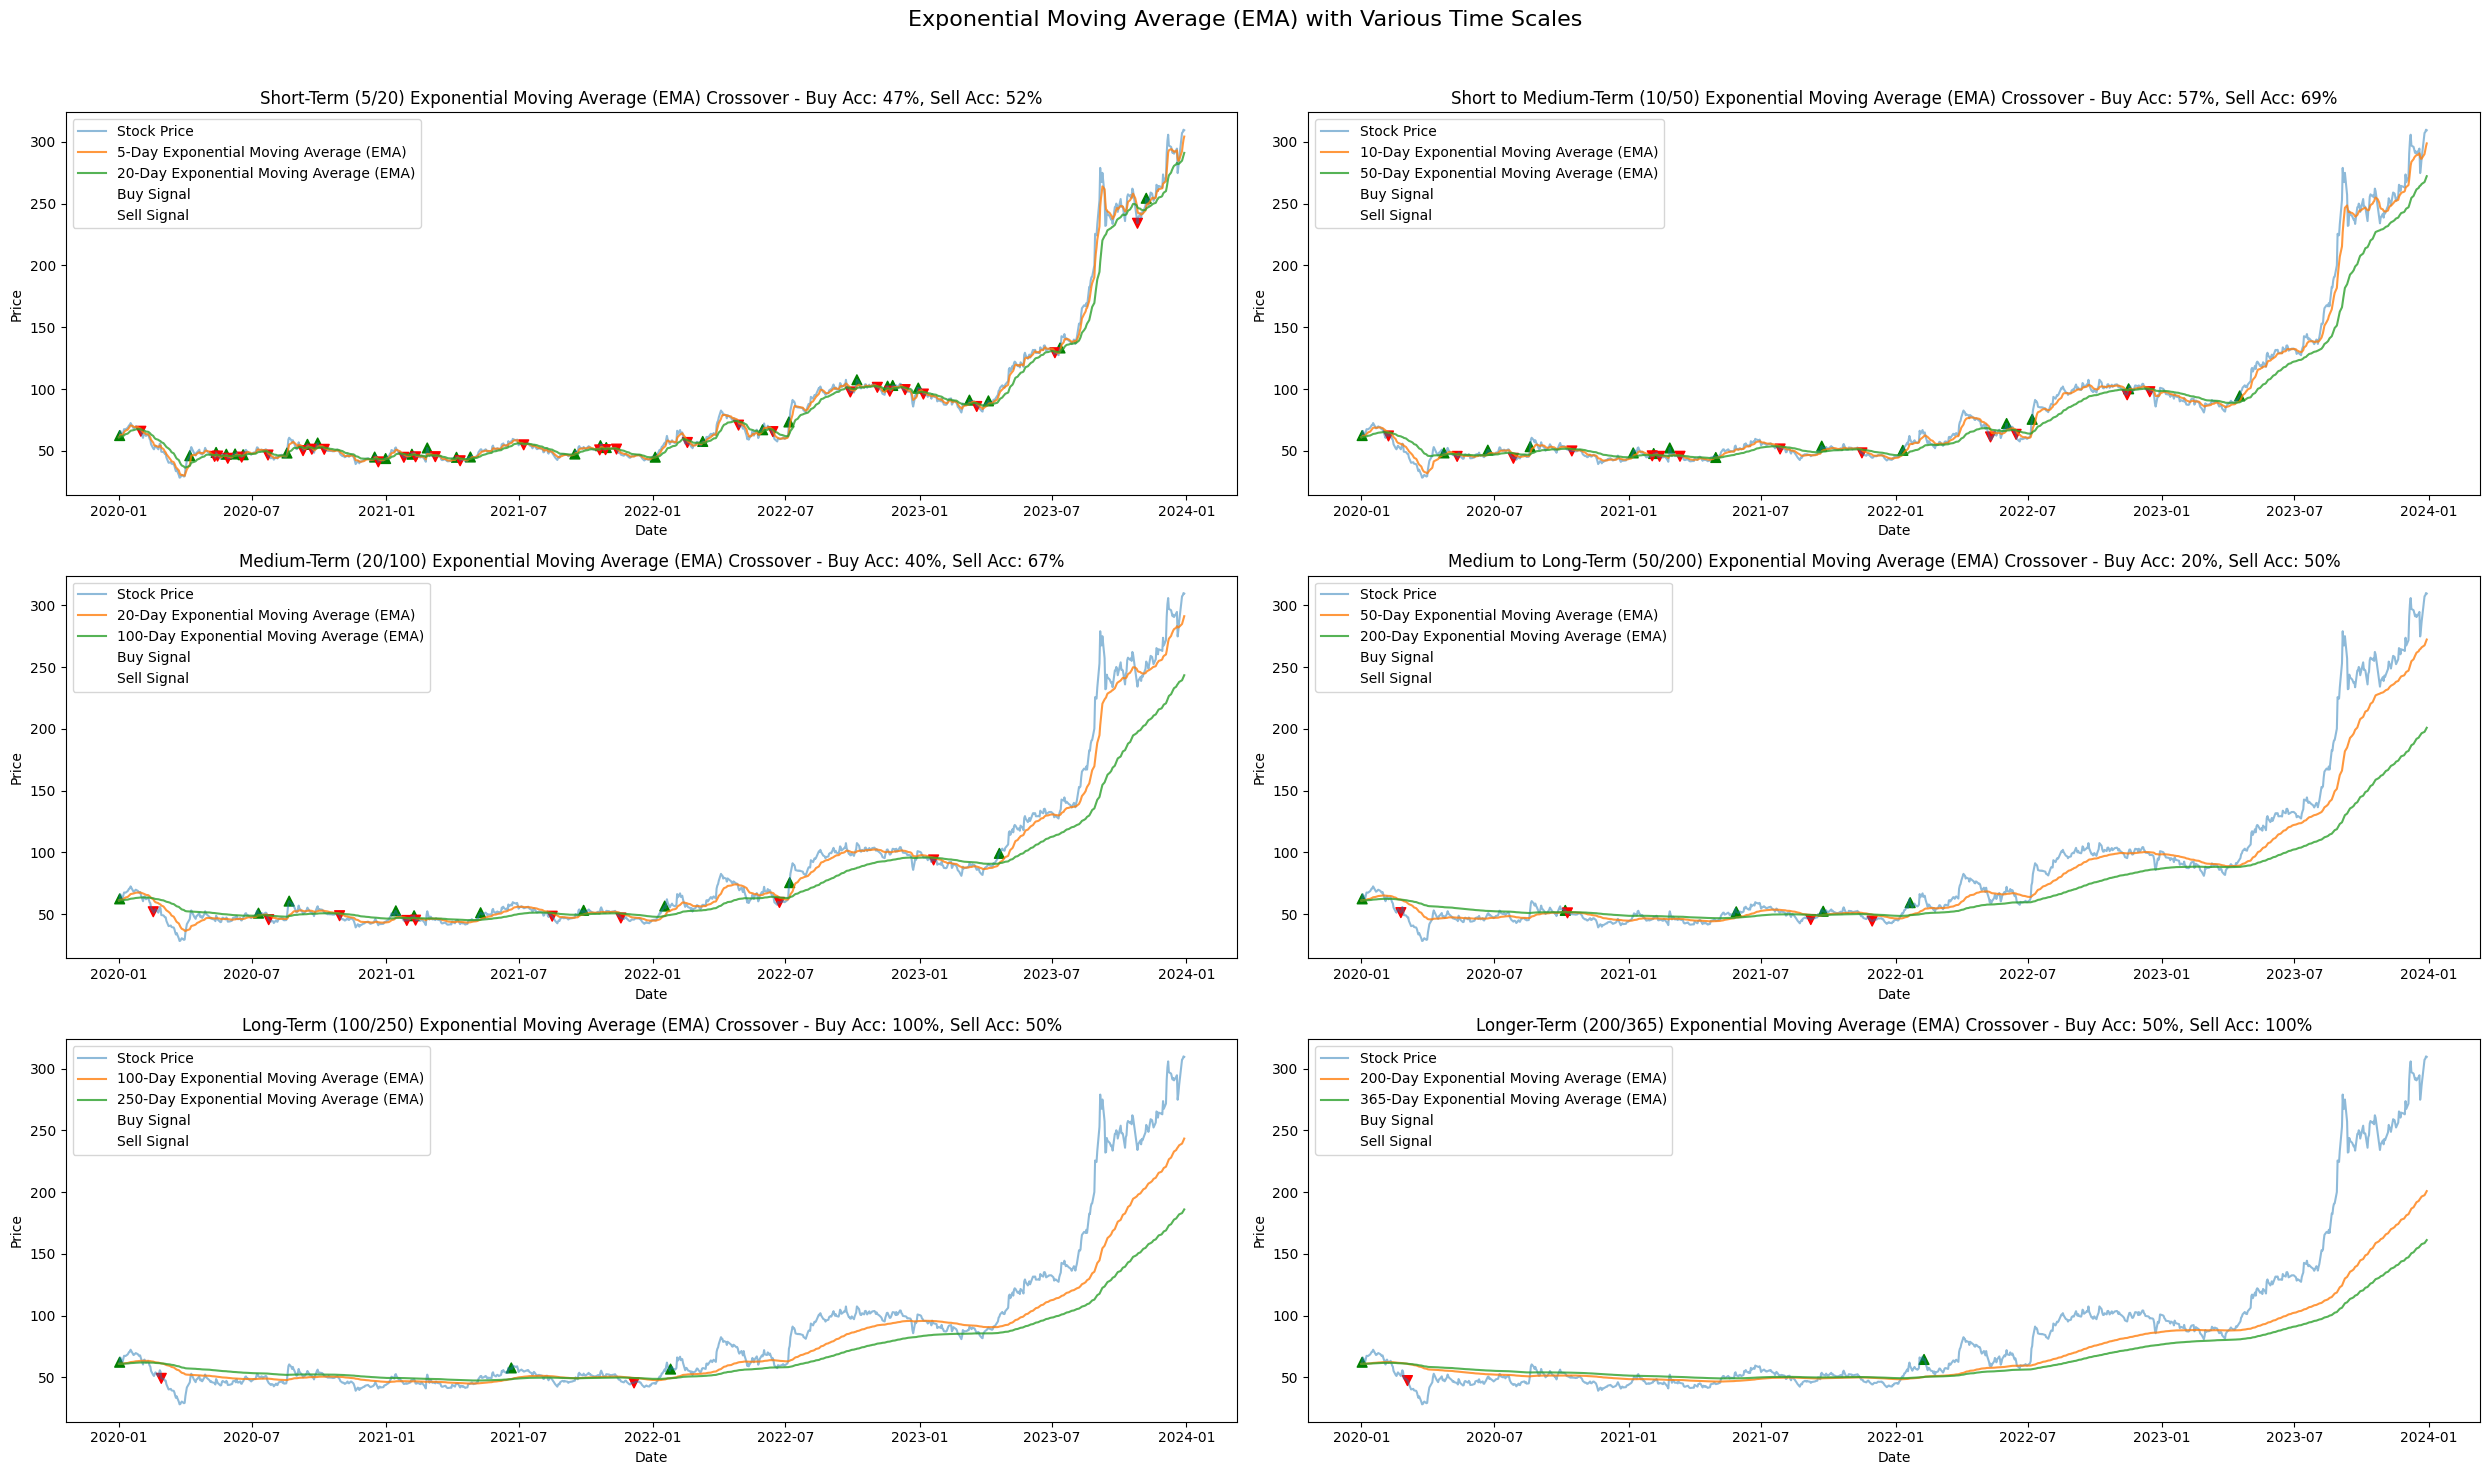

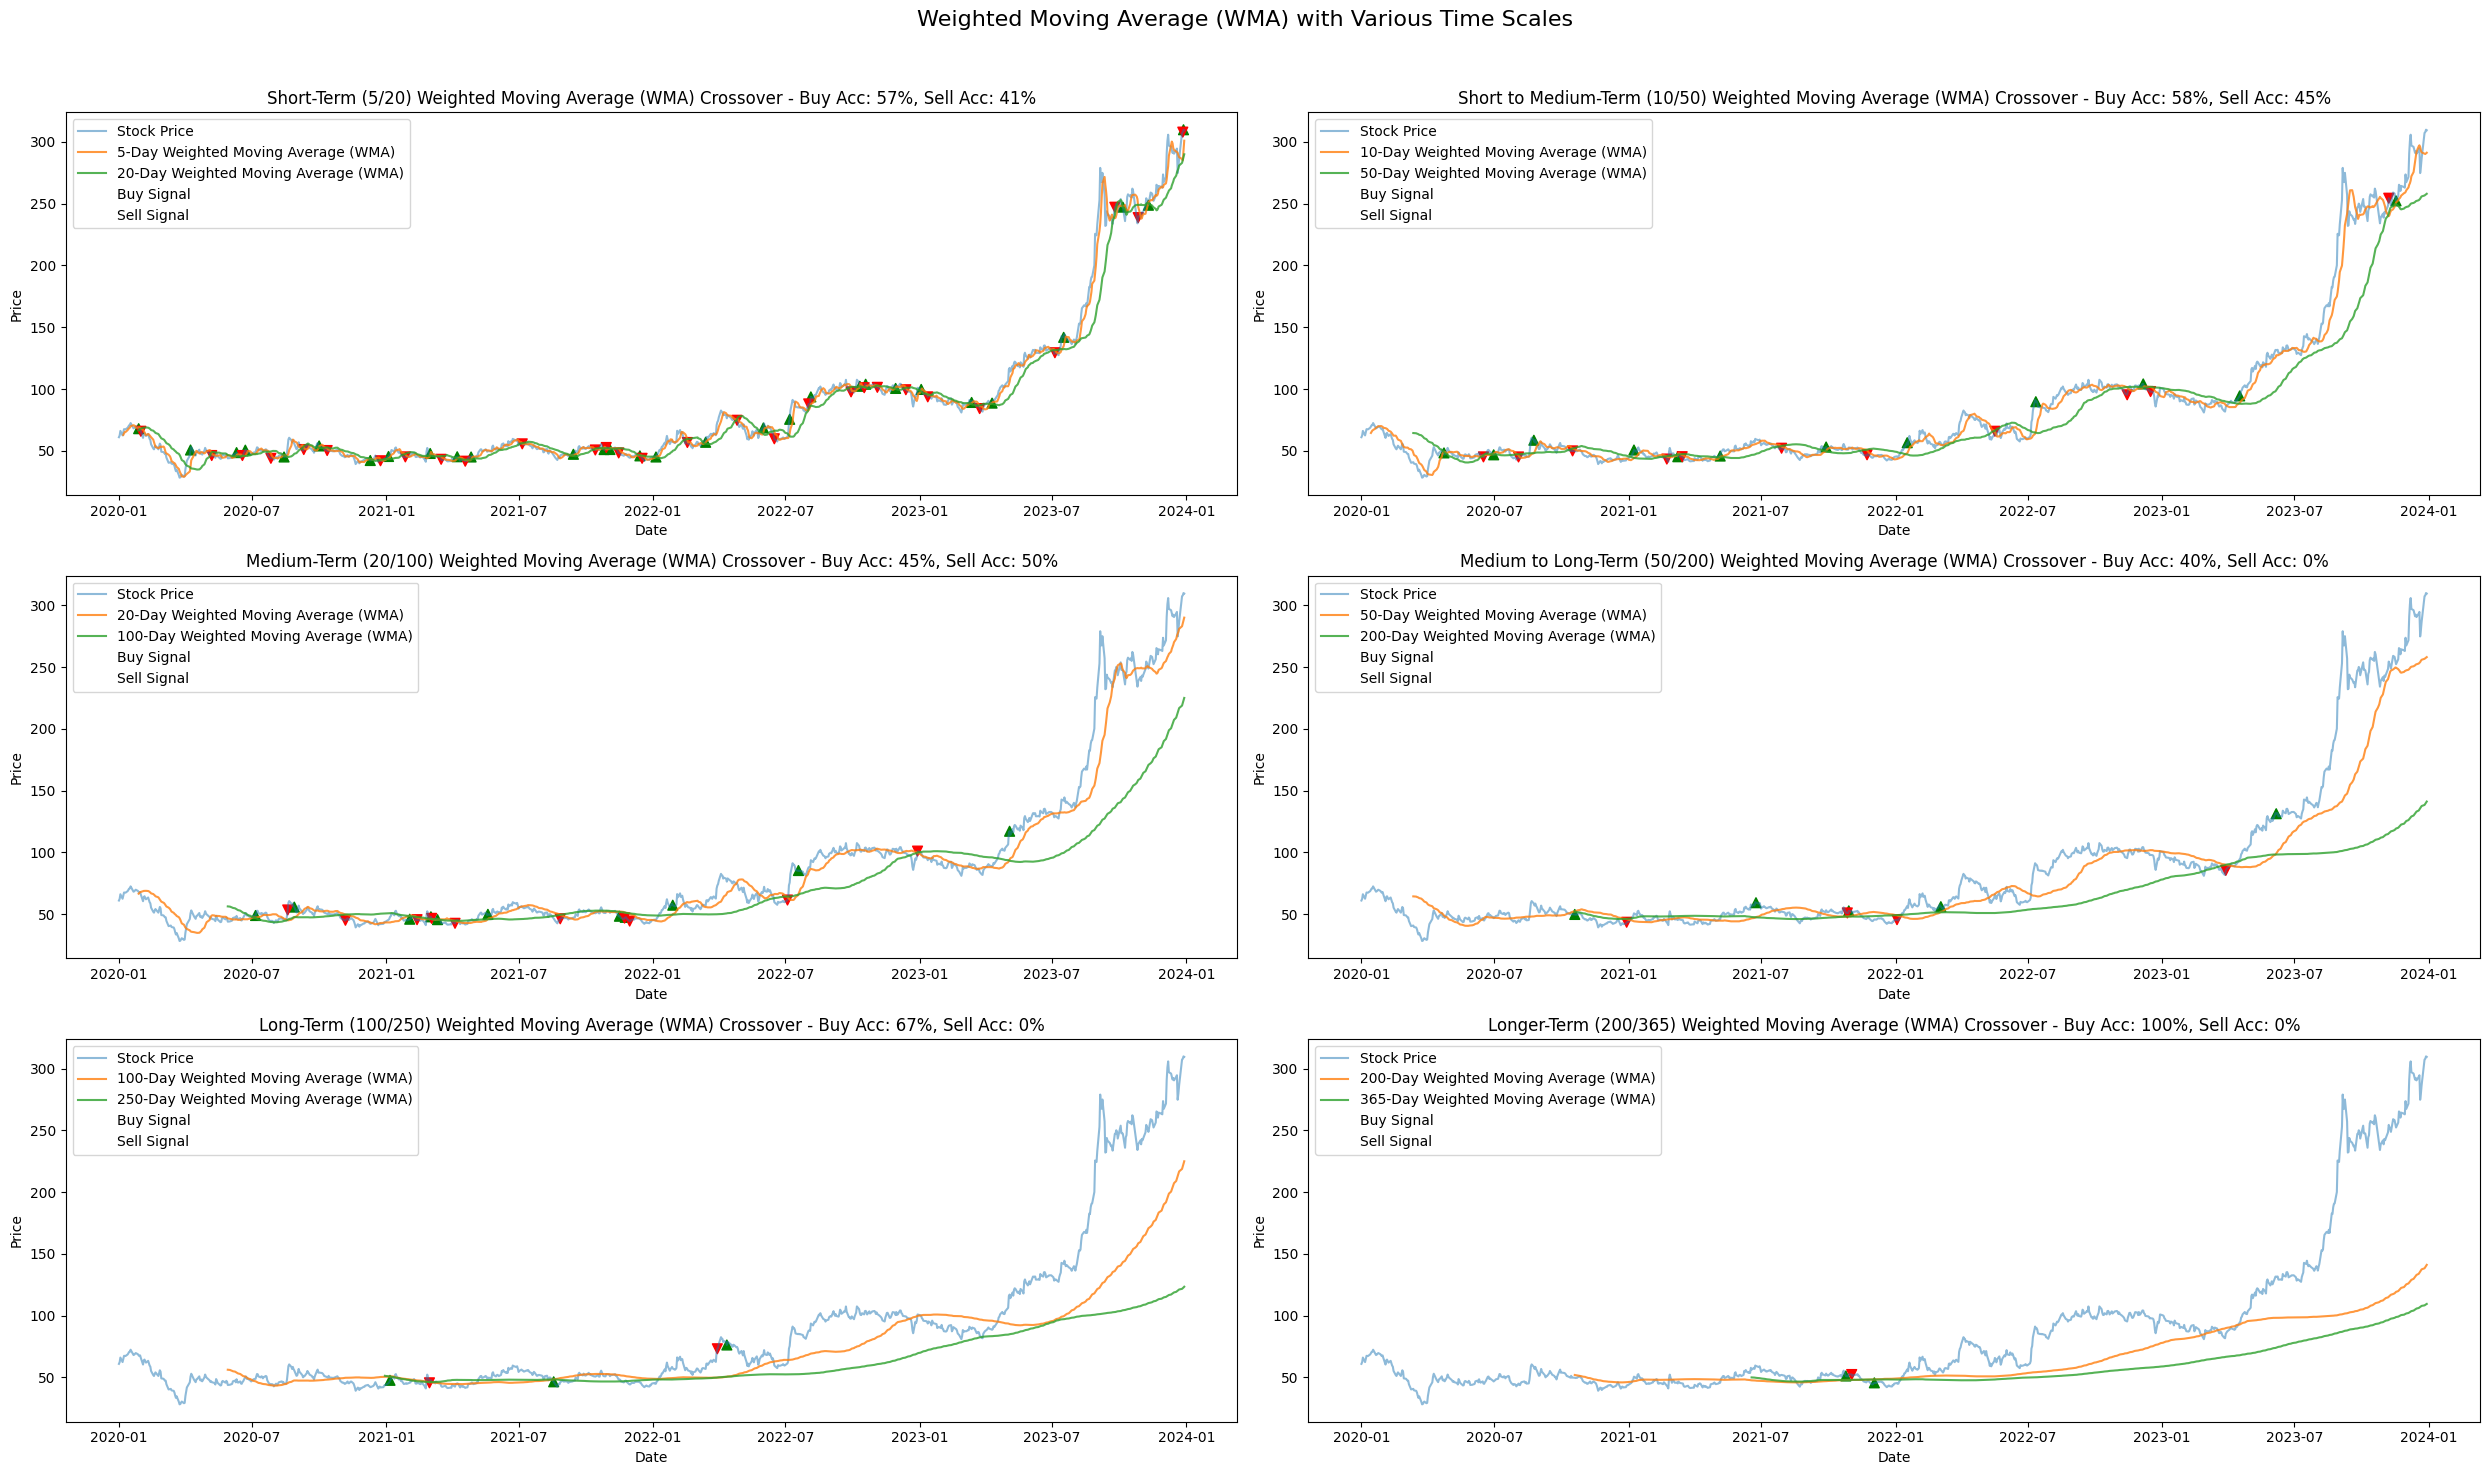

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Fetch stock data
def fetch_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    return data

# SMA Function
def SMA(data, window):
    return data.rolling(window=window).mean()

# EMA Function
def EMA(data, window):
    return data.ewm(span=window, adjust=False).mean()

# WMA Function
def WMA(data, window):
    weights = np.arange(1, window + 1)
    return data.rolling(window=window).apply(lambda prices: np.dot(prices, weights[::-1])/weights.sum(), raw=True)

# Identify buy and sell signals
def identify_signals(data, short_window, long_window, ma_function):
    data['Short_MA'] = ma_function(data['Close'], short_window)
    data['Long_MA'] = ma_function(data['Close'], long_window)
    data['Signal'] = 0
    data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1.0, 0.0)
    data['Positions'] = data['Signal'].diff()
    return data

# Calculate accuracy
def calculate_accuracy(data):
    data['Future_Close'] = data['Close'].shift(-5)  # Looking 5 days ahead
    buys = data[(data['Positions'] == 1) & (data['Close'] < data['Future_Close'])]
    sells = data[(data['Positions'] == -1) & (data['Close'] > data['Future_Close'])]
    buy_accuracy = len(buys) / len(data[data['Positions'] == 1]) if len(data[data['Positions'] == 1]) > 0 else np.nan
    sell_accuracy = len(sells) / len(data[data['Positions'] == -1]) if len(data[data['Positions'] == -1]) > 0 else np.nan
    return buy_accuracy, sell_accuracy

# Plotting Function for Moving Averages with signals
def plot_ma_signals(stock_data, combinations, ma_function, ma_label):
    fig, axs = plt.subplots(3, 2, figsize=(25, 15))
    fig.suptitle(f'{ma_label} with Various Time Scales', fontsize=16)

    term_labels = {
        (5, 20): "Short-Term (5/20)",
        (10, 50): "Short to Medium-Term (10/50)",
        (20, 100): "Medium-Term (20/100)",
        (50, 200): "Medium to Long-Term (50/200)",
        (100, 250): "Long-Term (100/250)",
        (200, 365): "Longer-Term (200/365)"
    }

    for i, (short_window, long_window) in enumerate(combinations, 1):
        data = identify_signals(stock_data.copy(), short_window, long_window, ma_function)
        buy_accuracy, sell_accuracy = calculate_accuracy(data)
        term_label = term_labels.get((short_window, long_window), f"{short_window}/{long_window}")

        ax = axs[(i-1)//2, (i-1)%2]
        ax.plot(data.index, data['Close'], label='Stock Price', alpha=0.5)
        ax.plot(data.index, data['Short_MA'], label=f'{short_window}-Day {ma_label}', alpha=0.8)
        ax.plot(data.index, data['Long_MA'], label=f'{long_window}-Day {ma_label}', alpha=0.8)
        ax.scatter(data.index, data['Close'], label='Buy Signal', marker='^', color='g', alpha=1, s=50 * data['Positions'].clip(lower=0))
        ax.scatter(data.index, data['Close'], label='Sell Signal', marker='v', color='r', alpha=1, s=50 * data['Positions'].clip(upper=0).abs())
        accuracy_title = f"Buy Acc: {buy_accuracy*100:.0f}%, Sell Acc: {sell_accuracy*100:.0f}%"
        ax.set_title(f'{term_label} {ma_label} Crossover - {accuracy_title}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Main Functions Execution
stock = 'HSCL.NS'
start_date = '2020-01-01'
end_date = '2024-01-01'
time_scale_combinations = [(5, 20), (10, 50), (20, 100), (50, 200), (100, 250), (200, 365)]

stock_data = fetch_data(stock, start_date, end_date)

# Plot for SMA
plot_ma_signals(stock_data, time_scale_combinations, SMA, "Simple Moving Average (SMA)")

# Plot for EMA
plot_ma_signals(stock_data, time_scale_combinations, EMA, "Exponential Moving Average (EMA)")

# Plot for WMA
plot_ma_signals(stock_data, time_scale_combinations, WMA, "Weighted Moving Average (WMA)")